# Séries temporais
### Simples análise de algoritmos de classificação utilizando séries temporais

Primeiramente, vamos criar uma série temporal sintética. É um vetor de quantidade de chuva (milímetros) em cada dia do ano. Para modelar, vamos supor que a quantidade de chuvas é uma onda senoidal ao longo do ano.

Uma onda senoidal pode ser definida como $y(t) = H+A~sin(2\pi f~t + \phi)$, com H sendo a altura, ou o valor do eixo y onde o seno é zero (múltiplos de $\pi$), A é a amplitude da onda, ou a altura máxima que a onda chega (em relação à altura H), f é a frequência, ou o número de ondas por ciclo, e por fim $\phi$ é a fase, ou o deslocamento da onda.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import linear_model

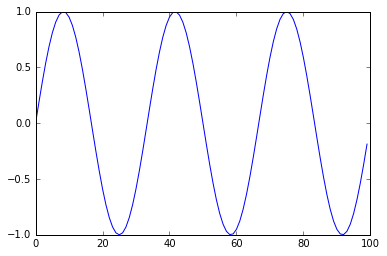

In [28]:
def onda_senoidal(altura, amplitude, frequencia, fase, passos):
    t = np.arange(passos)
    return altura + amplitude * np.sin(2 * np.pi * frequencia * t + fase)

x = np.arange(100)
y = onda_senoidal(altura=0, amplitude=1, frequencia=0.03, fase=0, passos=100)
plt.plot(x, y);

Para modelar nosso exemplo da chuva, pensemos que a onda pode variar de 0 a 300 milímetros de chuva. Portanto, utilizaremos uma amplitude de 150 e uma altura de 150. A frequência é de uma onda a cada ano, portanto $f = \frac{1}{365}$. Modelaremos ainda o mês de janeiro, ou mais especificamente o dia 1 de janeiro, como o pico das chuvas, e o mês de junho como o dia mais baixo de chuva; para isso, a defasagem deve ser de um quarto do tamanho da onda, multiplicado pela frequência angular, logo, $\frac{365}{4}\omega = \frac{365}{4}\frac{1}{365}2\pi = \frac{\pi}{2}$.

O gráfico abaixo mostra a quantidade de chuva medida a cada dia, ao longo de 5 anos, com $t=0$ indicando o dia 1 de janeiro do ano 0, e $t=1825$ (o último dia) sendo 31 de dezembro do ano 4.

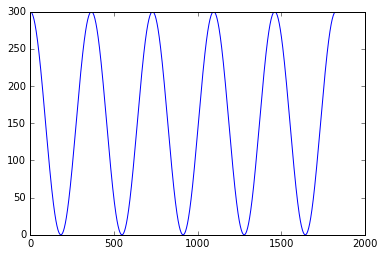

In [29]:
t = 365 * 5 # 5 anos
x = np.arange(t)
y = onda_senoidal(altura=150, amplitude=150, frequencia=1.0/365, fase=np.pi/2, passos=t)
plt.plot(x, y);

### Ruídos

Para analisar algoritmos de classificação para este problema, devemos adicionar um pouco de ruído para gerar algumas dificuldades no aprendizado, facilitando a análise do viés indutivo. Adicionaremos uma variável aleatória $R \sim N(\mu=20, \sigma^2=30)$ na nossa série temporal. Precisaremos também truncar a série para ser positiva, não existe valores negativos de chuva!

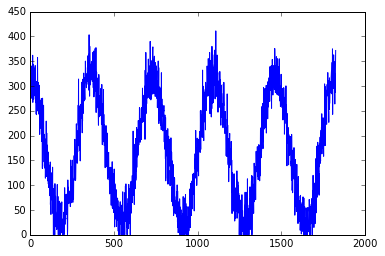

In [30]:
n = len(y)
r = 30.0 * np.random.randn(n) + 20
y = y + r
y[y < 0] = 0

plt.plot(x, y);

### Classificação

##### Discretização

Para nos retermos na classificação e não na tarefa de regressão, faremos a discretização da série acima. Para valores entre 0 e 80, consideraremos que houve "pouca ou nenhuma chuva". Para valores entre 80 e 200, consideraremos que houve "chuva leve", e para valores maiores que 200 consideraremos que houve "chuva forte".

In [31]:
def converter(v):
    if 0 < v < 80:
        return 0
    elif 80 <= v < 200:
        return 1
    else:
        return 2

c = [converter(i) for i in y]
print(c[70:90])

[2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]


##### Representação dos dados

Para representar os dados de forma tabular para a classificação, iremos considerar como dimensões o nível de chuva dos últimos cem dias.

In [32]:
data = []
for i in range(101, len(c)):
    data.append(c[i - 101 : i])

colunas = list(reversed(["1 dia antes"] + ["{0} dias antes".format(i) for i in range(2, 101)])) + ["Classe"]
df = pd.DataFrame(data, columns=colunas)
df.head()

,100 dias antes,99 dias antes,98 dias antes,97 dias antes,96 dias antes,95 dias antes,94 dias antes,93 dias antes,92 dias antes,91 dias antes,...,9 dias antes,8 dias antes,7 dias antes,6 dias antes,5 dias antes,4 dias antes,3 dias antes,2 dias antes,1 dia antes,Classe
0,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,2,1,1,2,1,1
1,2,2,2,2,2,2,2,2,2,2,...,1,1,1,2,1,1,2,1,1,1
2,2,2,2,2,2,2,2,2,2,2,...,1,1,2,1,1,2,1,1,1,1
3,2,2,2,2,2,2,2,2,2,2,...,1,2,1,1,2,1,1,1,1,1
4,2,2,2,2,2,2,2,2,2,2,...,2,1,1,2,1,1,1,1,1,1


In [33]:
index = []
for i in range(len(df)):
    index.append("Y{0}D{1}".format(i // 365, i % 365))
df["dia"] = index
df = df.set_index("dia")
df.head()

,100 dias antes,99 dias antes,98 dias antes,97 dias antes,96 dias antes,95 dias antes,94 dias antes,93 dias antes,92 dias antes,91 dias antes,...,9 dias antes,8 dias antes,7 dias antes,6 dias antes,5 dias antes,4 dias antes,3 dias antes,2 dias antes,1 dia antes,Classe
dia,,,,,,,,,,,,,,,,,,,,,
Y0D0,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,2,1,1,2,1,1
Y0D1,2,2,2,2,2,2,2,2,2,2,...,1,1,1,2,1,1,2,1,1,1
Y0D2,2,2,2,2,2,2,2,2,2,2,...,1,1,2,1,1,2,1,1,1,1
Y0D3,2,2,2,2,2,2,2,2,2,2,...,1,2,1,1,2,1,1,1,1,1
Y0D4,2,2,2,2,2,2,2,2,2,2,...,2,1,1,2,1,1,1,1,1,1


##### Classificadores

Aqui colocaremos os classificadores Naive-Bayes (versão gaussiana), Decision Tree (CART), Regressão Linear e Regressão Logística.

In [34]:
nb = GaussianNB()
dt = tree.DecisionTreeClassifier()
ols = linear_model.LinearRegression()
lr = linear_model.LogisticRegression()

In [35]:
X = df.drop(['Classe'], axis=1)
Y = df['Classe']

In [36]:
for classificador, nome in [(nb, "Naive-Bayes"), (dt, "DecisionTree"), (ols, "Regressão Linear"), (lr, "Regressão Logística")]:
    score = cross_val_score(classificador, X, Y, cv=10)
    print "Acurácia do classificador {0}: {1}".format(nome, score.mean())

Acurácia do classificador Naive-Bayes: 0.693239537321
Acurácia do classificador DecisionTree: 0.738457858811
Acurácia do classificador Regressão Linear: 0.447057029147
Acurácia do classificador Regressão Logística: 0.750552741243
